<a href="https://colab.research.google.com/github/mitsuoxv/erp/blob/master/let_pres_speak_failed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let the presidents speak on economic matters

This is basically a copy of [NLP Zero to Hero](https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%204%20-%20Lesson%202%20-%20Notebook.ipynb). The only change is that the inputs are not Irish lyrics, but the United States Presidents' writings in the Economic Report of the President from 1947 to 2020.

## Preprocess

I started from the pdf files I downloaded for the [tf-idf](https://github.com/mitsuoxv/erp/blob/master/README.md) and [sentiment analysis](https://github.com/mitsuoxv/erp/blob/master/Sentiment.md) in this repository. First, I made new pdf files which contain only the president parts by make_pres_pdf.py. Next, I extract texts into new files by make_pres_txt.py, which utilizes data_func.py I copied from [PDF Text Extraction in Python](https://towardsdatascience.com/pdf-text-extraction-in-python-5b6ab9e92dd).

Then I copied text files into 'texts/presidents/' directory, and manually cleaned up texts by:

1. correcting word order, where digitization made mistakes in shaping lines;

1. correcting words, where optical recognition made mistakes due to dirt, or the author apparently misspelled;

1. making punctuation common over reports, following my memory of ["The Mac is Not a Typewriter" by Robin P. Williams](https://www.goodreads.com/book/show/41600.The_Mac_is_Not_a_Typewriter), which I must have, but could not find now. As an exception, using minus mark instead of hyphen; and

1. changing lines, where I encounter ";", ":", "—" or "," and when I feel changed lines are natural if they were in President Johnson's reports.

I tried to be consistent over reports of different authors. Honestly, I am not sure whether "text" has become more consistent or not, as a result.

I download the texts from 'texts/presidents/' directory.

In [ ]:
!wget https://raw.githubusercontent.com/mitsuoxv/erp/master/texts/presidents/{1947..2020}_pres.txt --directory-prefix=/tmp/

--2020-07-14 23:16:46--  https://raw.githubusercontent.com/mitsuoxv/erp/master/texts/presidents/1947_pres.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3322 (3.2K) [text/plain]
Saving to: ‘/tmp/1947_pres.txt’

1947_pres.txt       100%[===================>]   3.24K  --.-KB/s    in 0s      

2020-07-14 23:16:46 (49.6 MB/s) - ‘/tmp/1947_pres.txt’ saved [3322/3322]

--2020-07-14 23:16:46--  https://raw.githubusercontent.com/mitsuoxv/erp/master/texts/presidents/1948_pres.txt
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 25989 (25K) [text/plain]
Saving to: ‘/tmp/1948_pres.txt’

1948_pres.txt       100%[===================>]  25.38K  --.-KB/s    in 0.01s   

2020-07-14 23:16:46 (2.02 MB/s) - ‘/

In [ ]:
corpus = []

for year in range(1947, 2020):
    input_filename = '/tmp/{}_pres.txt'.format(year)
    
    with open(input_filename, 'r') as f:
        text = f.read()
    
    corpus = corpus + text.lower().split('\n')

I remove bullet only lines.

In [ ]:
import re

corpus = [re.sub('^.$', '', line) for line in corpus]
corpus = [re.sub('^\\(.\\)$', '', line) for line in corpus]
corpus = [re.sub('^.\\.$', '', line) for line in corpus]

corpus = [line for line in corpus if line != '']

So far the number of lines are:

In [ ]:
len(corpus)

12990

I remove the lines of which number of words is equal to, or greater than 35, as I know those can be regarded as exceptions from [Sentiment analysis using R](https://github.com/mitsuoxv/erp/blob/master/Sentiment.md)

In [ ]:
corpus = [line for line in corpus if len(re.split('[ —]', line)) < 35]

The number of lines are:

In [ ]:
len(corpus)

12077

In [ ]:
import tensorflow as tf

tf.__version__

'2.2.0'

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [ ]:
print(total_words)

9176


In [ ]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

As model.fit is expected to take aproximately 33 hours, it stopped at 186th epock. Probably Colab does not allow this long.

In [ ]:
history = model.fit(xs, ys, epochs=500, verbose=1)

Epoch 1/500
6111/6111 [==============================] - 231s 38ms/step - loss: 6.5237 - accuracy: 0.0879
Epoch 2/500
6111/6111 [==============================] - 233s 38ms/step - loss: 5.9432 - accuracy: 0.1349
Epoch 3/500
6111/6111 [==============================] - 232s 38ms/step - loss: 5.6382 - accuracy: 0.1565
Epoch 4/500
6111/6111 [==============================] - 231s 38ms/step - loss: 5.4439 - accuracy: 0.1677
Epoch 5/500
6111/6111 [==============================] - 230s 38ms/step - loss: 5.2938 - accuracy: 0.1802
Epoch 6/500
6111/6111 [==============================] - 230s 38ms/step - loss: 5.1702 - accuracy: 0.1906
Epoch 7/500
6111/6111 [==============================] - 231s 38ms/step - loss: 5.0676 - accuracy: 0.1976
Epoch 8/500
6111/6111 [==============================] - 230s 38ms/step - loss: 4.9716 - accuracy: 0.2044
Epoch 9/500
6111/6111 [==============================] - 230s 38ms/step - loss: 4.8885 - accuracy: 0.2096
Epoch 10/500
6111/6111 [======================

In [ ]:
model.summary()

NameError: ignored

In [ ]:
print(model)

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

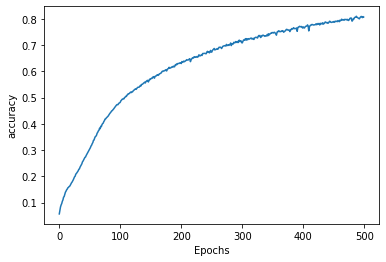

In [ ]:
plot_graphs(history, 'accuracy')

## Text Generation

I put the seed text as below. The model will generate 100 words after the seed text.

In [ ]:
seed_text = "I have some proposals to the Congress"
next_words = 100

In [ ]:
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
I have some proposals to the Congress presented 1947 that i have included in the people and the policy for a few days i have a month earlier resources in a rate of prices and wages which more permanently sustainable rates of the vast public debt and to check year improved services to sustained economic situation to deal with the situation points up generally i evaluate it should should i evaluate i deal show i evaluate wholesale control of our program among as of deflationary pressures of living through hospitals and to savings and credit wages prosperity to reduce of low incomes health or strikes soon as


Looks like English. Sounds like presidential?

My ambition was to create some A. I. Presidents, like a Democrat President or a Republican President, and let them talk about health care, tax, trade, etc. However, the generated texts so far are not convincing. 